In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Stickyfy'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.models as model
import os
from PIL import Image
from matplotlib import image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import cv2
import h5py
%matplotlib inline
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")

In [3]:
# Functions to pre process cartoon image
def remove_alpha(image, bg_color = (255,255,255)):
  if image.mode == 'RGBA':
    alpha = image.split()[-1]
    bg = Image.new("RGB", image.size, bg_color + (255,))
    bg.paste(image, mask=alpha)
    return bg
  else:
    return image
    
def preprocess(image):
  img_with_bg = remove_alpha(image)
  res_img = img_with_bg.resize((128,128))
  return res_img

class custom(object):
  def __call__(self, image):
    return remove_alpha(image)

In [4]:
class dataset_h5(torch.utils.data.Dataset):
  def __init__(self, in_file, transforms):
    super(dataset_h5, self).__init__()
    self.file = h5py.File(in_file, 'r')
    self.transform = transforms
    self.n_images = len((self.file).keys())

  def __getitem__(self, index):
      input = self.file['X'+str(index)][:,:,:]
      input = Image.fromarray(input)
      input = self.transform(input)
      return input

  def __len__(self):
      return self.n_images

In [5]:
img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize(32),
                                       transforms.ToTensor(),
])
# cartoon_file = '/content/drive/My Drive/Stickyfy/cartoon_data.h5'
# cartoon_dataset_h5 = dataset_h5(cartoon_file, img_transforms)
# cartoon_loader = torch.utils.data.DataLoader(cartoon_dataset_h5, shuffle = True, batch_size = 256)
face_file = '/content/drive/My Drive/Stickyfy/face_data.h5'
face_dataset_h5 = dataset_h5(face_file, img_transforms)
face_loader = torch.utils.data.DataLoader(face_dataset_h5, shuffle = True, batch_size = 512)

In [6]:
class encoder_layers(nn.Module):
  def __init__(self, input_channels):
    super(encoder_layers, self).__init__()
    self.fc1 = nn.Linear(input_channels, 1024)
    self.mu_fc = nn.Linear(1024,512)
    self.var_fc = nn.Linear(1024,512)
    self.relu = nn.ReLU()
  def forward(self, X):
    fin = self.relu(self.fc1(X))
    mu = self.relu(self.mu_fc(fin))
    var = self.relu(self.var_fc(fin))
    return (mu,var)

class Unflatten(nn.Module):
  def __init__(self,N,C,H,W):
    super(Unflatten, self).__init__()
    self.N = N
    self.W = W
    self.H = H
    self.C = C
  def forward(self,X):
    return X.view(self.N, self.C, self.H, self.W)


class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
  def forward(self, x):
    N = x.shape[0]
    return x.view(N,-1)

def initialize_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    nn.init.xavier_uniform_(m.weight.data)
  
resnet18 = model.resnet18()
modules=list(resnet18.children())[:-3]
resnet18 = nn.Sequential(
    *modules
)
initialize_weights(resnet18)
resnet18.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [7]:
def encoder_model(out_size):
  model = nn.Sequential(
      # Input is 32x32x3
      resnet18,
      # Input is 2x2x256
      Flatten(),
      encoder_layers(out_size)
  )
  return model

def decoder_model():
  model = nn.Sequential(
      nn.Linear(512, 1024),
      Unflatten(-1, 256, 2, 2),
      nn.ConvTranspose2d(256,128,kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(),
      nn.BatchNorm2d(128),
      nn.ConvTranspose2d(128,64,kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(),
      nn.BatchNorm2d(64),
      nn.ConvTranspose2d(64,32,kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(),
      nn.BatchNorm2d(32),
      nn.ConvTranspose2d(32,16,kernel_size = 4, stride = 2, padding = 1),
      nn.Conv2d(16,3, kernel_size = 3, padding = 1, stride = 1),
      nn.Tanh(),
  )
  return model

In [8]:
def sample(mu, var, mode):
  temp = torch.randn_like(var)
  temp = temp.type(dtype)
  if mode == 'Training':
    z = mu + temp * var
  else:
    z = mu
  return z

In [9]:
import time
import math
lr = 0.0005
def train_vae(encoder, decoder, data_loader, print_every = 5, num_epoch = 1, k = 0.1, eps = 1e-8):
  global lr
  encode_optimizer = optim.Adam(encoder.parameters(), lr = lr, betas = (0.5, 0.999), weight_decay=1e-5)
  decode_optimizer = optim.Adam(decoder.parameters(), lr = lr, betas = (0.5, 0.999), weight_decay=1e-5)
  losses = []
  kl_losses = []
  rec_losses = []
  for i in np.arange(num_epoch):
    data_iter = iter(data_loader)
    count = 0
    rec_loss = 0.0
    kl_loss = 0.0
    sum_loss = 0.0
    while True:
      # start_time = time.time()
      try:
        batch = data_iter.next()
      except StopIteration:
        if i%print_every == print_every-1:
          print("Epoch :- {}, loss = {}, kl_loss = {}, rec_loss = {}".format(i+1, sum_loss/count, kl_loss/count, rec_loss/count))
        losses.append(sum_loss/count)
        kl_losses.append(kl_loss/count)
        rec_losses.append(rec_loss/count)
        if i%8==7:
          lr/=4
        break
      except Exception as e:
        continue
      # print("Time for loading data = {}".format(time.time() - start_time))
      batch = batch.type(dtype)
      N = batch.shape[0]
      # start_time = time.time()
      count+=1
      mu, var = encoder(batch)
      z = sample(mu, var, 'Training')
      f_image = decoder(z)
      loss = torch.mean(torch.square(f_image - batch))
      rec_loss += loss
      kl_loss = (0.5 * torch.mean(torch.mean(torch.square(mu) + var - torch.log(var + eps) - 1,1)))
      loss = loss + k*kl_loss
      kl_loss += kl_loss
      sum_loss += loss
      encoder.zero_grad()
      decoder.zero_grad()
      loss.backward()
      encode_optimizer.step()
      decode_optimizer.step()
      # print("Time for opertaions = {}".format(time.time() - start_time))
  return losses, kl_losses, rec_losses

In [10]:
encoder = encoder_model(2*2*256)
decoder = decoder_model()
encoder.to(device)
decoder.to(device)
initialize_weights(encoder)
initialize_weights(decoder)
# torch.nn.utils.clip_grad_value_(encoder.parameters(), 10)
# torch.nn.utils.clip_grad_value_(decoder.parameters(), 10)

In [18]:
loss, kl_loss, rec_loss = train_vae(encoder, decoder, face_loader, print_every = 1, num_epoch = 50, k = 0.1, eps = 1e-8)

Epoch :- 1, loss = 0.02747401036322117, kl_loss = 0.0009544867789372802, rec_loss = 0.023880602791905403
Epoch :- 2, loss = 0.027378518134355545, kl_loss = 0.0009568340028636158, rec_loss = 0.0237886905670166
Epoch :- 3, loss = 0.027297019958496094, kl_loss = 0.0009545309585519135, rec_loss = 0.023709837347269058
Epoch :- 4, loss = 0.027202056720852852, kl_loss = 0.0009559205500409007, rec_loss = 0.023617541417479515
Epoch :- 5, loss = 0.027183791622519493, kl_loss = 0.000956547970417887, rec_loss = 0.023601310327649117
Epoch :- 6, loss = 0.027122974395751953, kl_loss = 0.0009519405430182815, rec_loss = 0.02354196086525917
Epoch :- 7, loss = 0.02705593779683113, kl_loss = 0.0009541599429212511, rec_loss = 0.02347593568265438
Epoch :- 8, loss = 0.027026008814573288, kl_loss = 0.0009565734071657062, rec_loss = 0.023446854203939438
Epoch :- 9, loss = 0.026989158242940903, kl_loss = 0.000951819063629955, rec_loss = 0.023410916328430176
Epoch :- 10, loss = 0.026947835460305214, kl_loss = 0.

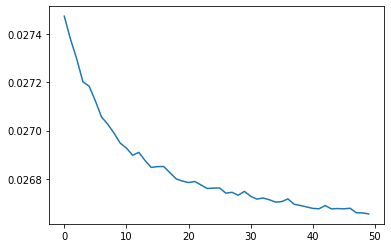

In [19]:
range = np.arange(50)
loss_t = []
for l in loss:
  loss_t.append(float(l.squeeze()))
plt.plot(range, loss_t)

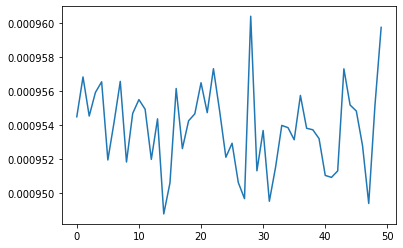

In [20]:
range = np.arange(50)
loss_t = []
for l in kl_loss:
  loss_t.append(float(l.squeeze()))
plt.plot(range, loss_t)

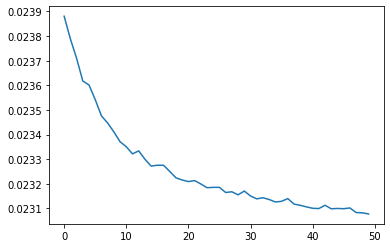

In [21]:
range = np.arange(50)
loss_t = []
for l in rec_loss:
  loss_t.append(float(l.squeeze()))
plt.plot(range, loss_t)

In [22]:
# Test images loader
target_path = '/content/drive/My Drive/Stickyfy/Test_images/cropped_faces/'
def test_data_loader(data_dir):
  img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize((32,32)),
                                       transforms.ToTensor(),
  ])
  test_data = datasets.ImageFolder(data_dir, transform = img_transforms)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1)
  return test_loader

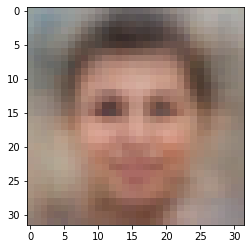

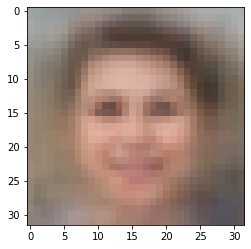

In [23]:
# Final tests
test_loader = test_data_loader(target_path)
i = 0
with torch.no_grad():
  for image,_ in test_loader:
    trans = transforms.ToPILImage(mode='RGB')
    image = image.type(dtype)
    mu, var = encoder(image)
    z = sample(mu, var, 'Testing')
    # print(z)
    img2 = decoder(z)
    img2 = img2.to(torch.device('cpu'))
    img = trans(img2.squeeze())
    r,g,b = img.split()
    img = Image.merge('RGB', (b,g,r))
    plt.imshow(img)
    plt.show()
# mu_test = (torch.normal(0.,1., size = (1,1))).type(dtype)
# var_test = (torch.abs(torch.normal(0.,1., size = (1,1)))).type(dtype)
# z = sample(mu_test, var_test)
# img2 = decoder(z)
# img2 = img2.to(torch.device('cpu'))
# plt.imshow(trans(img2.squeeze()))
# plt.show()

In [24]:
path = '/content/drive/My Drive/Stickyfy/Models/'
torch.save(encoder.state_dict(), path+'face_encoder.pt')
torch.save(decoder.state_dict(), path+'face_decoder.pt')